Optimized MLR Performance:
MAE: 138.4878, MSE: 36038.0185, RMSE: 189.8368, MAPE: 0.2222% 



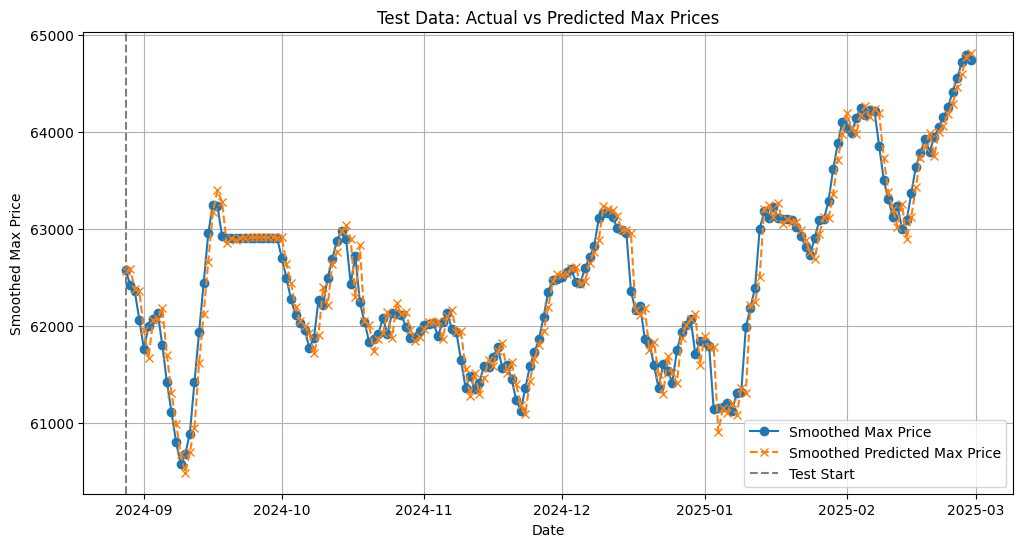

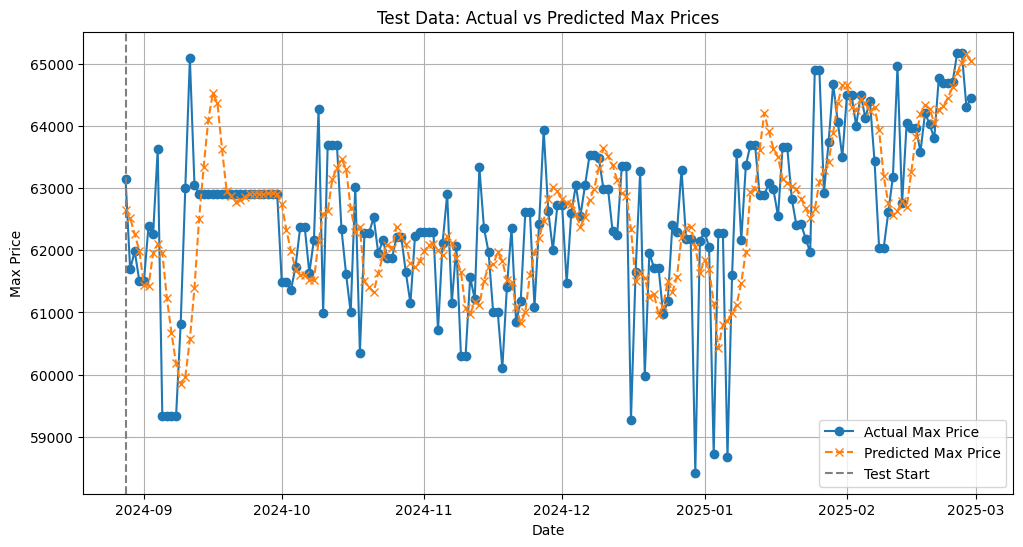

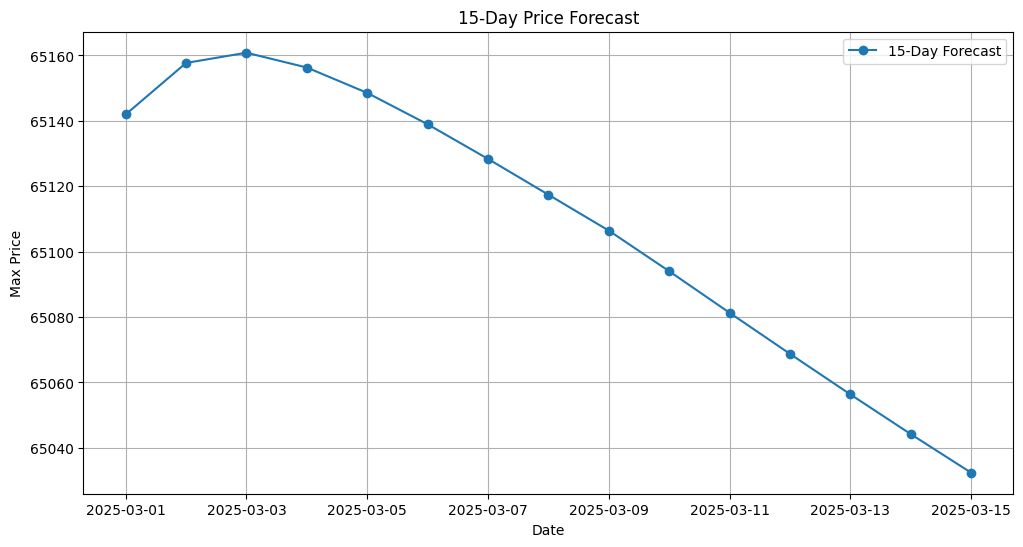

Analysis completed. Results saved to 'Price_Forecast_Results.xlsx'


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Read Source file
file_path = "PepperData2019-24-latest-Till-Feb2025.xlsx"
df_data = pd.read_excel(file_path, sheet_name="Sheet1")
df_data["Date"] = pd.to_datetime(df_data["Date"]).dt.strftime("%m-%d-%y")

# Filter for specific districts
df_copy = df_data[df_data['District'].isin(['Uttara Kannada', 'Dakshina Kannada', 'Udupi'])]

# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for Max price
filtered_df = remove_outliers(df_copy, 'Max')
filtered_df.reset_index(drop=True, inplace=True)

# Filling missing values
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])
grouped_df = filtered_df.groupby('Date').agg(
    Max=('Max', 'mean'),
    Min=('Min', 'mean'),
    Modal=('Modal', 'mean'),
    Sum_Arrival=('Arrivals', 'mean')
).reset_index()

grouped_df.set_index('Date', inplace=True)
date_range = pd.date_range(start=grouped_df.index.min(), end=grouped_df.index.max())
grouped_df = grouped_df.reindex(date_range, fill_value=np.nan)
grouped_df.fillna(method='ffill', inplace=True)
grouped_df.reset_index(inplace=True)
grouped_df.rename(columns={'index': 'Date'}, inplace=True)

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define performance evaluation function
def evaluate_performance(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}%\n")
    return mae, mse, rmse, mape

# Load dataset
df = grouped_df.copy()

# Ensure 'Date' is in datetime format and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Filter dataset to include data up to the end date
end_date = df.index.max()
test_start_date = end_date - pd.DateOffset(months=6)
df = df[df.index <= end_date]

# Apply rolling mean smoothing
df['Smoothed_Max'] = df['Max'].rolling(window=7, min_periods=1).mean()

# Compute past 7-day weight distribution
for i in range(7):
    df[f'Weight_Day{i+1}'] = df['Max'].shift(i) / df['Smoothed_Max'].shift(i)

df['Weight_Avg'] = df[[f'Weight_Day{i+1}' for i in range(7)]].mean(axis=1)
df.dropna(inplace=True)

# Feature Engineering
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month

# Create lag features
for lag in range(1, 5):
    df[f'Lag{lag}'] = df['Smoothed_Max'].shift(lag)

df.dropna(inplace=True)

# Split train-test based on last 6 months
df_train = df[df.index < test_start_date]
df_test = df[df.index >= test_start_date]

# Define features and target
features = ['DayOfWeek', 'Month', 'Lag1', 'Lag2', 'Lag3', 'Lag4']
target = 'Smoothed_Max'

X_train, y_train = df_train[features], df_train[target]
X_test, y_test = df_test[features], df_test[target]

# Train Model
mlr = LinearRegression()
mlr.fit(X_train, y_train)

# Predictions
df_test['Smoothed_Predicted_Max'] = mlr.predict(X_test)

# Convert smoothed predicted values to actual price predictions
df_test['Weighted_Predicted_Max'] = df_test['Smoothed_Predicted_Max'] * df_test['Weight_Avg']

# Evaluate Performance
evaluate_performance(df_test['Smoothed_Max'], df_test['Smoothed_Predicted_Max'], "Optimized MLR")

# Forecasting for next 15 days
forecast_start = end_date + pd.DateOffset(days=1)
forecast_end = forecast_start + pd.DateOffset(days=14)

forecast_dates = pd.date_range(start=forecast_start, end=forecast_end)
forecast_values = []

last_values = df.iloc[-1][['Lag1', 'Lag2', 'Lag3', 'Lag4']].values

for next_date in forecast_dates:
    next_features = np.array([next_date.dayofweek, next_date.month] + list(last_values)).reshape(1, -1)
    next_pred = mlr.predict(next_features)[0]
    last_values = np.roll(last_values, 1)
    last_values[0] = next_pred
    forecast_values.append(next_pred)

forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted_Smoothed_Max': forecast_values})
forecast_df.set_index('Date', inplace=True)

# Convert smoothed forecast to actual daily prices using recent weight distribution
latest_weight_avg = df['Weight_Avg'].iloc[-7:].values
forecast_df['Actual_Forecasted_Max'] = forecast_df['Forecasted_Smoothed_Max'] * latest_weight_avg.mean()

# Create output DataFrame for test data
test_results = df_test[['Smoothed_Max','Max', 'Smoothed_Max', 'Smoothed_Predicted_Max', 'Weighted_Predicted_Max']].copy()
test_results.reset_index(inplace=True)
test_results.rename(columns={
    'Max': 'Actual_Max_Price',
    'Smoothed_Max': 'Actual_Smoothed_Max',
    'Smoothed_Predicted_Max': 'Predicted_Smoothed_Max',
    'Weighted_Predicted_Max': 'Predicted_Actual_Max'
}, inplace=True)

# Prepare forecast DataFrame
forecast_output = forecast_df.reset_index()
forecast_output.rename(columns={
    'Forecasted_Smoothed_Max': 'Forecasted_Smoothed_Max',
    'Actual_Forecasted_Max': 'Forecasted_Actual_Max'
}, inplace=True)

# Save to Excel
with pd.ExcelWriter("Price_Forecast_Results.xlsx") as writer:
    test_results.to_excel(writer, sheet_name="Test_Results", index=False)
    forecast_output.to_excel(writer, sheet_name="15_Day_Forecast", index=False)

# Plot results

plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test['Smoothed_Max'], label='Smoothed Max Price', marker='o')
plt.plot(df_test.index, df_test['Smoothed_Predicted_Max'], label='Smoothed Predicted Max Price', linestyle='dashed', marker='x')
plt.axvline(x=test_start_date, color='gray', linestyle='--', label='Test Start')
plt.legend()
plt.title("Test Data: Actual vs Predicted Max Prices")
plt.xlabel('Date')
plt.ylabel('Smoothed Max Price')
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test['Max'], label='Actual Max Price', marker='o')
plt.plot(df_test.index, df_test['Weighted_Predicted_Max'], label='Predicted Max Price', linestyle='dashed', marker='x')
plt.axvline(x=test_start_date, color='gray', linestyle='--', label='Test Start')
plt.legend()
plt.title("Test Data: Actual vs Predicted Max Prices")
plt.xlabel('Date')
plt.ylabel('Max Price')
plt.grid(True)
plt.show()

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df['Actual_Forecasted_Max'], label='15-Day Forecast', marker='o')
plt.legend()
plt.title("15-Day Price Forecast")
plt.xlabel('Date')
plt.ylabel('Max Price')
plt.grid(True)
plt.show()

print("Analysis completed. Results saved to 'Price_Forecast_Results.xlsx'")